### Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def scatter_cat_pair_three(
    real_df: pd.DataFrame,
    syn_no_df: pd.DataFrame,
    syn_hfgf_df: pd.DataFrame,
    A: str,
    B: str,
    n_points: int = 5000,
    jitter: float = 0.15,
    random_state: int = 42,
    use_jitter: bool = True,
    drop_unseen: bool = True,
    savepath: str | None = None
):
    """
    Make 3 scatter plots (Real / No-HFGF / With-HFGF) for two (categorical) features A vs B.

    Notes:
    - Categories are encoded using REAL's category order for consistency across plots.
    - If use_jitter=True, Gaussian noise is added to show overplotting density.
    """

    rng = np.random.default_rng(random_state)

    # ---- sample for readability ----
    def _sample(df):
        d = df[[A, B]].dropna()
        if n_points is not None and len(d) > n_points:
            d = d.sample(n_points, random_state=random_state)
        return d.copy()

    R = _sample(real_df)
    N = _sample(syn_no_df)
    H = _sample(syn_hfgf_df)
    
    def get_numeric_category_levels(df, col):
        return (
        pd.to_numeric(df[col], errors="coerce")
          .dropna()
          .round()
          .astype(int)
          .sort_values()
          .unique()
          .astype(str)
          .tolist()
    )


    # ---- shared category mapping based on REAL ----
    A_levels = get_numeric_category_levels(real_df, A)
    B_levels = get_numeric_category_levels(real_df, B)

    A_map = {k: i for i, k in enumerate(A_levels)}
    B_map = {k: i for i, k in enumerate(B_levels)}

    def _encode(d):
        a = d[A].astype(str).map(A_map)
        b = d[B].astype(str).map(B_map)

        if drop_unseen:
            mask = a.notna() & b.notna()
            a = a[mask]; b = b[mask]
        else:
            a = a.fillna(-1)
            b = b.fillna(-1)

        a = a.astype(float).to_numpy()
        b = b.astype(float).to_numpy()

        if use_jitter:
            a = a + rng.normal(0, jitter, size=len(a))
            b = b + rng.normal(0, jitter, size=len(b))

        return a, b

    datasets = [("Real", R), ("CTABGAN+ (without HFGF)", N), ("CTABGAN+ (with HFGF)", H)]

    fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

    for ax, (title, d) in zip(axs, datasets):
        x, y = _encode(d)
        ax.scatter(x, y, s=10, alpha=0.3, color="#4285F4", edgecolors="none")
        ax.set_title(title, fontsize=10)
        ax.set_xlabel(A)
        ax.set_ylabel(B)

        # ticks/labels (if too many categories, reduce A_levels/B_levels or use top-k)
        ax.set_xticks(range(len(A_levels)))
        ax.set_xticklabels(A_levels, rotation=45, ha="right", fontsize=7)
        ax.set_yticks(range(len(B_levels)))
        ax.set_yticklabels(B_levels, fontsize=7)

        # consistent limits
        ax.set_xlim(-0.5, len(A_levels) - 0.5)
        ax.set_ylim(-0.5, len(B_levels) - 0.5)

    #fig.suptitle(f"Scatter plots for categorical pair: {A} vs {B}", fontsize=14)
    
    #plt.savefig('feature_distribution_figures/ctabgan+.png', dpi=700, bbox_inches='tight')
    plt.show()


In [3]:
real_data = pd.read_csv('Real_simulated_data/adult_data_reduced.csv')

In [4]:
synthetic_data = pd.read_csv('Synthetic_data/ctabgan+/synthetic_ctabgan+_adult.csv')

In [5]:
synthetic_data[['education', 'education-num']]=synthetic_data[['education', 'education-num']].astype(int)

In [6]:
synthetic_data_hfgf = pd.read_csv('Synthetic_data/ctabgan+/synthetic_ctabgan+_adult_dependent_mapping.csv')

In [7]:
synthetic_data_hfgf[['education', 'education-num']]=synthetic_data_hfgf[['education', 'education-num']].astype(int)

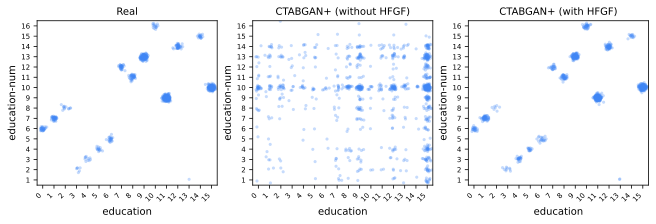

In [8]:
A = "education"
B = "education-num"

scatter_cat_pair_three(
    real_df=real_data,
    syn_no_df=synthetic_data,
    syn_hfgf_df=synthetic_data_hfgf,
    A=A,
    B=B,
    n_points=3000,
    use_jitter=True   # set False if you want exact grid points
)